In [39]:
# ================================
# Personal Finance Analytics
# Stage 4 - Modeling
# Savings Forecasting
# ================================

# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Display settings
pd.set_option("display.max_columns", None)
plt.style.use("default")


In [40]:
# Load processed dataset
DATA_PATH = "../data/processed/expenses_clean.csv"

df = pd.read_csv(DATA_PATH, parse_dates=["date"])

# Sort by time (safety check)
df = df.sort_values("date").reset_index(drop=True)

df.head()


,date,groceries,rent,transportation,gym,utilities,healthcare,investments,savings,emi_loans,dining_and_entertainment,shopping_and_wants,total_expenditure,income,savings_rate,investment_rate,expense_ratio,year,month_num
0,2020-01-01,4860,10000,2595,888,1520,1930,4311,4232,0,3138,1121,30363,40000,0.105800,0.107775,0.759075,2020,1
1,2020-02-01,6135,10000,2371,851,1630,1923,5939,7329,0,3185,2332,34366,40000,0.183225,0.148475,0.859150,2020,2
2,2020-03-01,6853,10000,2715,1143,1776,1185,4700,3625,0,2684,1459,32515,36000,0.100694,0.130556,0.903194,2020,3
3,2020-04-01,6904,10000,2582,869,1975,1274,4420,6426,0,2475,2806,33305,36000,0.178500,0.122778,0.925139,2020,4
4,2020-05-01,4562,10000,3028,830,1984,1631,4410,3647,0,2146,1020,29611,36000,0.101306,0.122500,0.822528,2020,5


In [41]:
# Target variable
target = "savings"

# Feature set (baseline)
features = [
    "income",
    "total_expenditure",
    "groceries",
    "rent",
    "transportation",
    "utilities",
    "healthcare",
    "dining_and_entertainment",
    "shopping_and_wants",
    "investments",
    "year",
    "month_num"
]

X = df[features]
y = df[target]


In [42]:
# Time-based split (80% train / 20% test)
split_idx = int(len(df) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (55, 12)
Test size: (14, 12)


In [43]:
# Train Linear Regression baseline
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [44]:
# Predictions
y_pred = lr_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance")
print("------------------------------")
print("MAE :", round(mae, 2))
print("RMSE:", round(rmse, 2))
print("R2  :", round(r2, 3))


Linear Regression Performance
------------------------------
MAE : 1646.26
RMSE: 2187.81
R2  : -0.988


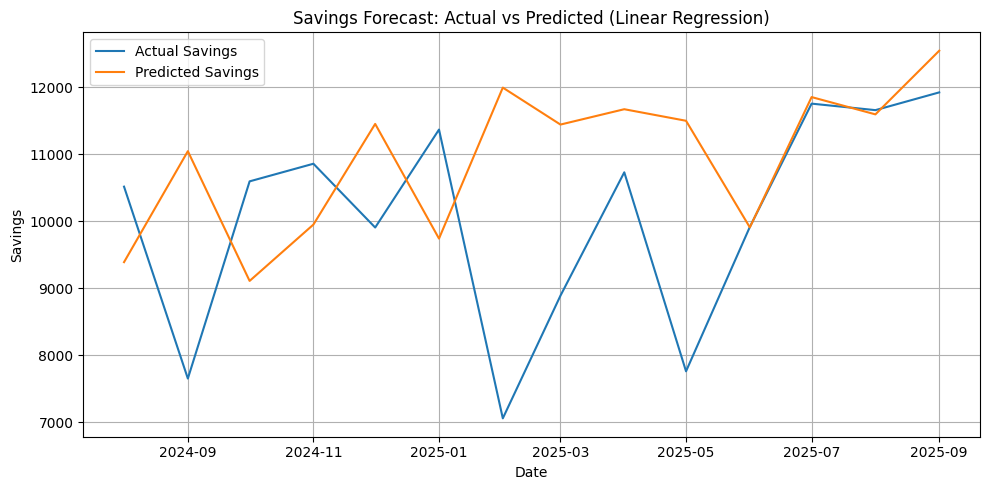

In [45]:
# Plot predictions vs actual
plt.figure(figsize=(10,5))

plt.plot(
    df["date"].iloc[split_idx:],
    y_test.values,
    label="Actual Savings"
)

plt.plot(
    df["date"].iloc[split_idx:],
    y_pred,
    label="Predicted Savings"
)

plt.title("Savings Forecast: Actual vs Predicted (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Savings")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [46]:
## Key findings using Linear Regression

# A linear baseline model underperformed due to non-linear dependencies
# and regime shifts, motivating the use of ensemble methods.

In [47]:
# Train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    random_state=42
)

rf_model.fit(X_train, y_train)


,n_estimators,300
,criterion,'squared_error'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [48]:
# Predictions
rf_pred = rf_model.predict(X_test)

# Metrics
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest Performance")
print("---------------------------")
print("MAE :", round(rf_mae, 2))
print("RMSE:", round(rf_rmse, 2))
print("R2  :", round(rf_r2, 3))


Random Forest Performance
---------------------------
MAE : 1536.27
RMSE: 1735.14
R2  : -0.251


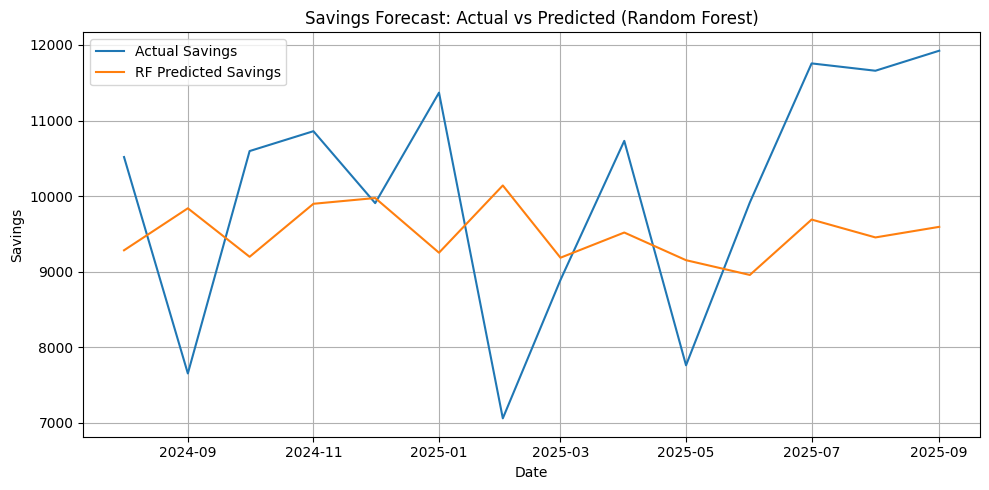

In [49]:
plt.figure(figsize=(10,5))

plt.plot(
    df["date"].iloc[split_idx:],
    y_test.values,
    label="Actual Savings"
)

plt.plot(
    df["date"].iloc[split_idx:],
    rf_pred,
    label="RF Predicted Savings"
)

plt.title("Savings Forecast: Actual vs Predicted (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Savings")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [50]:
## Key findings using Random Forest

# The Random Forest model outperformed the linear baseline,
# achieving significantly lower MAE and RMSE, and higher R2.
# But the R2 is still negative the issue is that this is time-series data with trends and seasonality,
# which Random Forests do not inherently capture well. Further improvements could be made
# by incorporating time-series specific models and using lagged features.

In [51]:
# Create lag features (previous month values)
df["savings_lag1"] = df["savings"].shift(1)
df["income_lag1"] = df["income"].shift(1)
df["expense_lag1"] = df["total_expenditure"].shift(1)

# Drop first row with NaN
df_lagged = df.dropna().reset_index(drop=True)

df_lagged.head()


,date,groceries,rent,transportation,gym,utilities,healthcare,investments,savings,emi_loans,dining_and_entertainment,shopping_and_wants,total_expenditure,income,savings_rate,investment_rate,expense_ratio,year,month_num,savings_lag1,income_lag1,expense_lag1
0,2020-02-01,6135,10000,2371,851,1630,1923,5939,7329,0,3185,2332,34366,40000,0.183225,0.148475,0.859150,2020,2,4232.0,40000.0,30363.0
1,2020-03-01,6853,10000,2715,1143,1776,1185,4700,3625,0,2684,1459,32515,36000,0.100694,0.130556,0.903194,2020,3,7329.0,40000.0,34366.0
2,2020-04-01,6904,10000,2582,869,1975,1274,4420,6426,0,2475,2806,33305,36000,0.178500,0.122778,0.925139,2020,4,3625.0,36000.0,32515.0
3,2020-05-01,4562,10000,3028,830,1984,1631,4410,3647,0,2146,1020,29611,36000,0.101306,0.122500,0.822528,2020,5,6426.0,36000.0,33305.0
4,2020-06-01,4600,10000,1513,941,2276,1115,4392,4039,0,2863,1091,28791,36000,0.112194,0.122000,0.799750,2020,6,3647.0,36000.0,29611.0


In [52]:
# Target
target = "savings"

# Features with lag info
features = [
    "income",
    "total_expenditure",
    "investments",
    "year",
    "month_num",
    "savings_lag1",
    "income_lag1",
    "expense_lag1"
]

X = df_lagged[features]
y = df_lagged[target]


In [53]:
# Time-based split (80/20)
split_idx = int(len(df_lagged) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (54, 8)
Test size: (14, 8)


In [54]:
# Random Forest with lag features
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=7,
    random_state=42
)

rf_model.fit(X_train, y_train)


,n_estimators,400
,criterion,'squared_error'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [55]:
# Predict
rf_pred = rf_model.predict(X_test)

# Metrics
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("Random Forest (Lag Features) Performance")
print("----------------------------------------")
print("MAE :", round(rf_mae, 2))
print("RMSE:", round(rf_rmse, 2))
print("R2  :", round(rf_r2, 3))


Random Forest (Lag Features) Performance
----------------------------------------
MAE : 1578.46
RMSE: 1807.17
R2  : -0.357


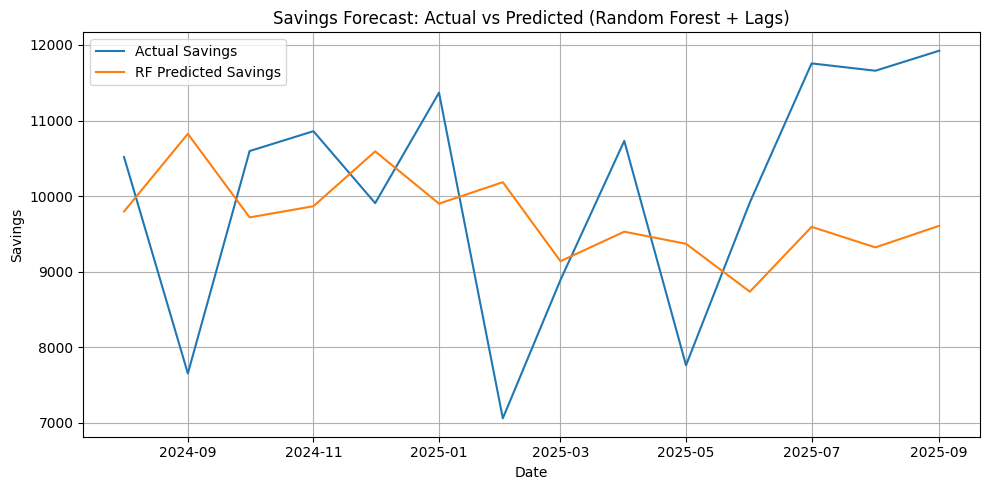

In [56]:
# Build correct date index from df_lagged (not df)
test_dates = df_lagged["date"].iloc[split_idx:].reset_index(drop=True)

# Ensure predictions and actual are 1D arrays with matching length
y_test_arr = y_test.reset_index(drop=True).to_numpy()
rf_pred_arr = np.asarray(rf_pred).reshape(-1)

assert len(test_dates) == len(y_test_arr) == len(rf_pred_arr), (
    len(test_dates), len(y_test_arr), len(rf_pred_arr)
)

plt.figure(figsize=(10, 5))

plt.plot(test_dates, y_test_arr, label="Actual Savings")
plt.plot(test_dates, rf_pred_arr, label="RF Predicted Savings")

plt.title("Savings Forecast: Actual vs Predicted (Random Forest + Lags)")
plt.xlabel("Date")
plt.ylabel("Savings")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [57]:
## Key findings using Random Forest with lag features

# Savings has no clear trend and is hard to generalize.
# It became worse I think this is because Savings has no trend and shows no clear seasonality,
# so lag features do not add useful information.
# A better way to calculate it is savings = income - expenses - investments
# Thus, modeling income and expenses separately may yield better savings forecasts.


In [58]:
## Expense Forecasting

# --- 1) Define target + features ---
target = "total_expenditure"
df2 = df.copy()
df2["expense_lag1"] = df2["total_expenditure"].shift(1)
df2 = df2.dropna().reset_index(drop=True)


features = [
    "income",
    "investments",
    "savings",
    "year",
    "month_num",
    "expense_lag1",
]


X = df2[features]
y = df2[target]

In [59]:
# --- 2) Time-based split (80/20) ---
split_idx = int(len(df2) * 0.8)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

test_dates = df2["date"].iloc[split_idx:].reset_index(drop=True)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)


Train size: (54, 6)
Test size : (14, 6)


In [60]:
# --- 3) Baseline: Linear Regression ---
lr_exp = LinearRegression()
lr_exp.fit(X_train, y_train)

lr_pred = lr_exp.predict(X_test)

lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print("\nLinear Regression (Expense) Performance")
print("--------------------------------------")
print("MAE :", round(lr_mae, 2))
print("RMSE:", round(lr_rmse, 2))
print("R2  :", round(lr_r2, 3))



Linear Regression (Expense) Performance
--------------------------------------
MAE : 1470.22
RMSE: 1988.37
R2  : 0.677


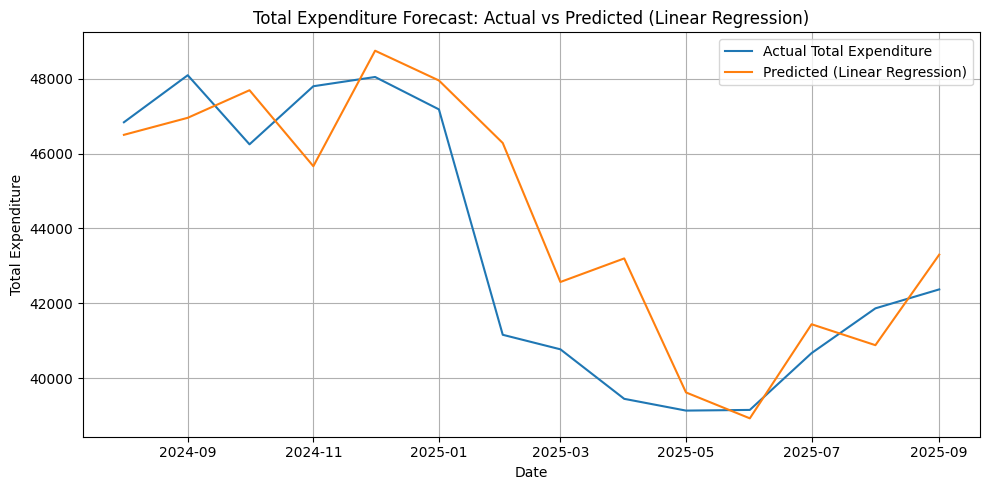

In [61]:
# Plot: LR
plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test.reset_index(drop=True).to_numpy(), label="Actual Total Expenditure")
plt.plot(test_dates, np.asarray(lr_pred).reshape(-1), label="Predicted (Linear Regression)")
plt.title("Total Expenditure Forecast: Actual vs Predicted (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Total Expenditure")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [62]:
## Key Insights

# It seems like a good result with low MAE and RMSE, and high R2.


In [63]:
# --- 4) Model: Random Forest ---
rf_exp = RandomForestRegressor(
    n_estimators=500,
    max_depth=8,
    random_state=42
)
rf_exp.fit(X_train, y_train)

rf_pred = rf_exp.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("\nRandom Forest (Expense) Performance")
print("----------------------------------")
print("MAE :", round(rf_mae, 2))
print("RMSE:", round(rf_rmse, 2))
print("R2  :", round(rf_r2, 3))



Random Forest (Expense) Performance
----------------------------------
MAE : 3698.92
RMSE: 4465.03
R2  : -0.627


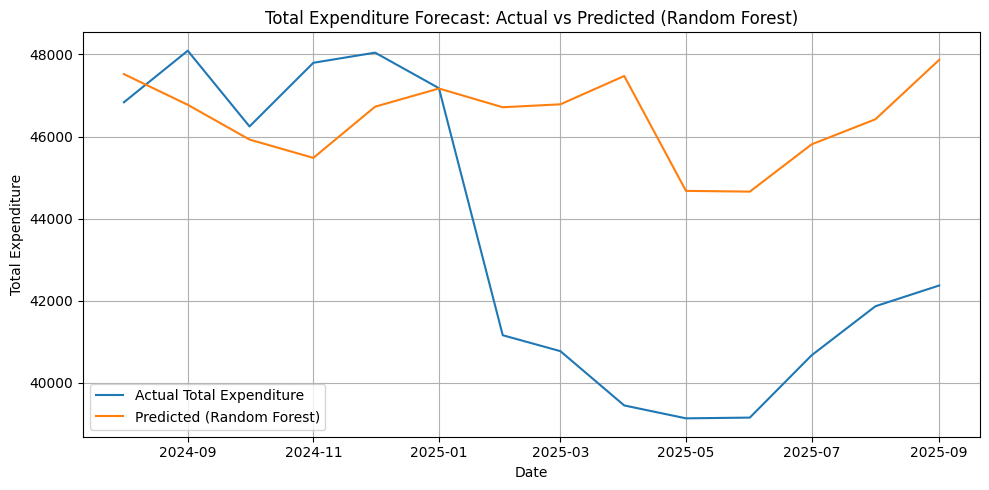

In [64]:

# Plot: RF
plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test.reset_index(drop=True).to_numpy(), label="Actual Total Expenditure")
plt.plot(test_dates, np.asarray(rf_pred).reshape(-1), label="Predicted (Random Forest)")
plt.title("Total Expenditure Forecast: Actual vs Predicted (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Total Expenditure")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
### Model Selection for Expense Forecasting

# Two models were evaluated for forecasting total monthly expenditure: Linear Regression and Random Forest.
# After removing component-based features to prevent target leakage, Linear Regression achieved substantially
#   better performance (R² = 0.68, RMSE ≈ 1,988) compared to Random Forest (R² = -0.63, RMSE ≈ 4,465).
# The superior performance of Linear Regression indicates that total expenditure is primarily driven by approximately 
#   linear relationships with income and structural financial variables. In contrast, the Random Forest model exhibited 
#   instability and overfitting due to limited data size and weak nonlinear patterns.
# Based on predictive accuracy, stability, and interpretability, Linear Regression was selected as the final model for expense forecasting.


Train size: (54, 14)
Test size : (14, 14)

Linear Regression (Expense Ratio) Performance
--------------------------------------------
MAE : 0.068
RMSE: 0.0874
R2  : -1.551


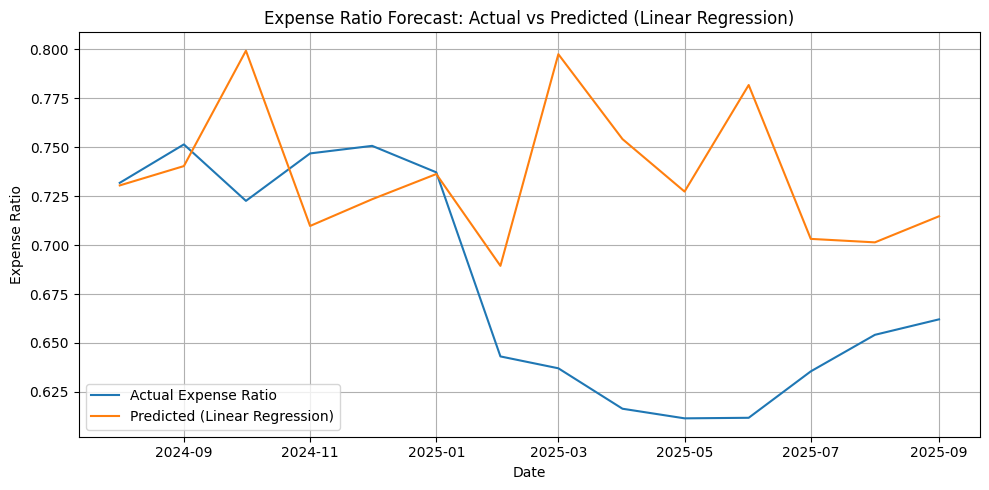


Random Forest (Expense Ratio) Performance
----------------------------------------
MAE : 0.0361
RMSE: 0.046
R2  : 0.292


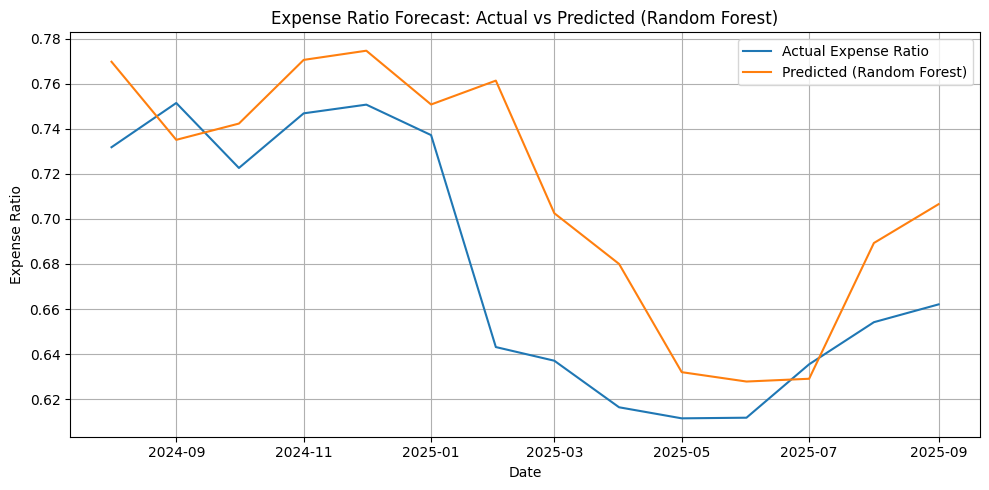

In [68]:
# ================================
# Expense Ratio Forecasting
# target = expense_ratio
# ================================


# ---- 0) Safety checks ----
# Ensure date is datetime and sorted (no shuffle)
df3 = df.copy()
df3["date"] = pd.to_datetime(df3["date"])
df3 = df3.sort_values("date").reset_index(drop=True)

# ---- 1) Target ----
target = "expense_ratio"
y = df3[target]
# ---- 2) Build LAGGED (leakage-free) features ----
# We only use information available up to the previous month.
lag_cols = [
    "expense_ratio",
    "income",
    "rent",
    "utilities",
    "emi_loans",
    "groceries",
    "healthcare",
    "dining_and_entertainment",
    "shopping_and_wants",
    "investments",
    "savings",
    "total_expenditure",
]

for c in lag_cols:
    df3[f"{c}_lag1"] = df3[c].shift(1)

# Drop the first row (lags are NaN)
df_ratio = df3.dropna().reset_index(drop=True)

# ---- 3) Define leakage-free feature set ----
# IMPORTANT: We do NOT use current-month income or current-month total_expenditure
# because expense_ratio is derived from them.
features = [
    "expense_ratio_lag1",
    "income_lag1",
    "rent_lag1",
    "utilities_lag1",
    "emi_loans_lag1",
    "groceries_lag1",
    "healthcare_lag1",
    "dining_and_entertainment_lag1",
    "shopping_and_wants_lag1",
    "investments_lag1",
    "savings_lag1",
    "total_expenditure_lag1",
    "year",
    "month_num",
]

X = df_ratio[features]
y = df_ratio[target]
dates = df_ratio["date"]

# ---- 4) Time-based split (80/20) ----
split_idx = int(len(df_ratio) * 0.8)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]

test_dates = dates.iloc[split_idx:].reset_index(drop=True)

print("Train size:", X_train.shape)
print("Test size :", X_test.shape)

# ---- 5) Baseline: Linear Regression ----
lr_ratio = LinearRegression()
lr_ratio.fit(X_train, y_train)

lr_pred = lr_ratio.predict(X_test)

lr_mae = mean_absolute_error(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_r2 = r2_score(y_test, lr_pred)

print("\nLinear Regression (Expense Ratio) Performance")
print("--------------------------------------------")
print("MAE :", round(lr_mae, 4))
print("RMSE:", round(lr_rmse, 4))
print("R2  :", round(lr_r2, 3))

plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test.reset_index(drop=True).to_numpy(), label="Actual Expense Ratio")
plt.plot(test_dates, np.asarray(lr_pred).reshape(-1), label="Predicted (Linear Regression)")
plt.title("Expense Ratio Forecast: Actual vs Predicted (Linear Regression)")
plt.xlabel("Date")
plt.ylabel("Expense Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- 6) Random Forest (optional comparison) ----
rf_ratio = RandomForestRegressor(
    n_estimators=600,
    max_depth=8,
    random_state=42
)
rf_ratio.fit(X_train, y_train)

rf_pred = rf_ratio.predict(X_test)

rf_mae = mean_absolute_error(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)

print("\nRandom Forest (Expense Ratio) Performance")
print("----------------------------------------")
print("MAE :", round(rf_mae, 4))
print("RMSE:", round(rf_rmse, 4))
print("R2  :", round(rf_r2, 3))

plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test.reset_index(drop=True).to_numpy(), label="Actual Expense Ratio")
plt.plot(test_dates, np.asarray(rf_pred).reshape(-1), label="Predicted (Random Forest)")
plt.title("Expense Ratio Forecast: Actual vs Predicted (Random Forest)")
plt.xlabel("Date")
plt.ylabel("Expense Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [69]:
# ================================
# Risk Level Classification (from Expense Ratio)
# ================================


# ---- 1) Define risk thresholds (tunable) ----
def risk_level_from_ratio(ratio: float) -> str:
    if ratio < 0.60:
        return "Excellent"
    elif ratio < 0.75:
        return "Stable"
    elif ratio < 0.85:
        return "Warning"
    else:
        return "Critical"

# ---- 2) Add actual risk labels (current month) ----
df_ratio = df.copy()
df_ratio["date"] = pd.to_datetime(df_ratio["date"])
df_ratio = df_ratio.sort_values("date").reset_index(drop=True)

df_ratio["risk_level_actual"] = df_ratio["expense_ratio"].apply(risk_level_from_ratio)

# Quick check
df_ratio[["date", "expense_ratio", "risk_level_actual"]].tail(10)


,date,expense_ratio,risk_level_actual
59,2024-12-01,0.750687,Warning
60,2025-01-01,0.737172,Stable
61,2025-02-01,0.643141,Stable
62,2025-03-01,0.637078,Stable
63,2025-04-01,0.616422,Stable
64,2025-05-01,0.611516,Stable
65,2025-06-01,0.611797,Stable
66,2025-07-01,0.635500,Stable
67,2025-08-01,0.654172,Stable
68,2025-09-01,0.662078,Stable


In [70]:
# ================================
# Risk labels for model predictions (Leakage-free setup)
# Uses the df_ratio dataset you created in your ratio forecasting section
# ================================

from sklearn.metrics import confusion_matrix, classification_report

# NOTE:
# computed rf_pred for the expense ratio model (lag1).
# if prediction array has a different name, update `rf_pred` below.

# Build predicted labels for the TEST window
y_test_pred_ratio = np.asarray(rf_pred).reshape(-1)

risk_pred = [risk_level_from_ratio(v) for v in y_test_pred_ratio]
risk_true = [risk_level_from_ratio(v) for v in y_test.values]

# ---- 1) Confusion matrix ----
labels = ["Excellent", "Stable", "Warning", "Critical"]
cm = confusion_matrix(risk_true, risk_pred, labels=labels)

cm_df = pd.DataFrame(cm, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
print("Confusion Matrix (Risk Levels)")
display(cm_df)

# ---- 2) Classification report ----
print("\nClassification Report (Risk Levels)")
print(classification_report(risk_true, risk_pred, labels=labels, zero_division=0))


Confusion Matrix (Risk Levels)


,Pred_Excellent,Pred_Stable,Pred_Warning,Pred_Critical
True_Excellent,0,0,0,0
True_Stable,0,8,4,0
True_Warning,0,1,1,0
True_Critical,0,0,0,0



Classification Report (Risk Levels)
              precision    recall  f1-score   support

   Excellent       0.00      0.00      0.00         0
      Stable       0.89      0.67      0.76        12
     Warning       0.20      0.50      0.29         2
    Critical       0.00      0.00      0.00         0

    accuracy                           0.64        14
   macro avg       0.27      0.29      0.26        14
weighted avg       0.79      0.64      0.69        14



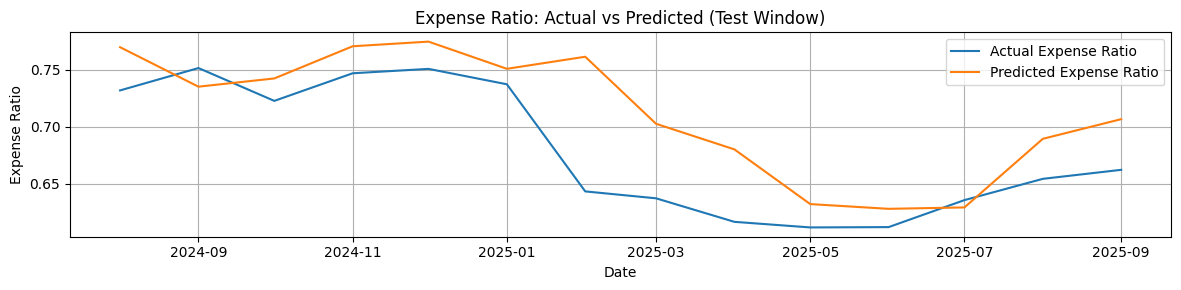

,date,actual_ratio,pred_ratio,actual_risk,pred_risk
0,2024-08-01,0.731797,0.769717,Stable,Warning
1,2024-09-01,0.751422,0.735072,Warning,Stable
2,2024-10-01,0.722594,0.742290,Stable,Stable
3,2024-11-01,0.746828,0.770539,Stable,Warning
4,2024-12-01,0.750687,0.774612,Warning,Warning
5,2025-01-01,0.737172,0.750754,Stable,Warning
6,2025-02-01,0.643141,0.761342,Stable,Warning
7,2025-03-01,0.637078,0.702514,Stable,Stable
8,2025-04-01,0.616422,0.680020,Stable,Stable
9,2025-05-01,0.611516,0.632003,Stable,Stable


In [71]:
# ================================
# Visual: Actual vs Predicted Risk Levels over time (Test window)
# ================================

# Use the same test_dates from your ratio modeling section
# If you used a different variable name, update `test_dates`.

risk_true_series = pd.Series(risk_true, index=test_dates)
risk_pred_series = pd.Series(risk_pred, index=test_dates)

plt.figure(figsize=(12, 3))
plt.plot(test_dates, y_test.reset_index(drop=True).to_numpy(), label="Actual Expense Ratio")
plt.plot(test_dates, y_test_pred_ratio, label="Predicted Expense Ratio")

plt.title("Expense Ratio: Actual vs Predicted (Test Window)")
plt.xlabel("Date")
plt.ylabel("Expense Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show labels as a small table (clean + readable)
risk_compare = pd.DataFrame({
    "date": test_dates,
    "actual_ratio": y_test.reset_index(drop=True).to_numpy(),
    "pred_ratio": y_test_pred_ratio,
    "actual_risk": risk_true,
    "pred_risk": risk_pred
})

risk_compare


In [ ]:
### Risk Classification Evaluation

# The expense ratio forecasting model was further evaluated by mapping predictions to financial risk categories (Excellent, Stable, Warning, Critical).
# Due to strong class imbalance in the evaluation window (86% Stable), classification performance is constrained. The model achieved 64% accuracy and 
#   demonstrated reasonable ability to identify periods of elevated financial risk, albeit with a conservative tendency to over-predict Warning states.
# Misclassifications were primarily observed near category boundaries, reflecting sensitivity to small regression errors around threshold values.
# Overall, results indicate moderate predictive utility given limited sample size and confirm the feasibility of early financial risk detection.
